# Koopman kernel models for TC Tracks

[Work in progress]

In [ ]:
# %matplotlib inline
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from kooplearn.models import Kernel, NystroemKernel
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
    TCTracks_from_TensorContextDataset,
    characteristic_length_scale_from_TCTracks,
    context_dataset_from_TCTracks,
    standardize_TensorContextDataset,
)
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
from klearn_tcyclone.models_utils import predict_time_series
from klearn_tcyclone.performance_benchmark import timer

from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)


## Train model

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2024-11-02 15:28:08,366 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


### Normalise data

In [3]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [4]:
scaler = LinearScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (8016, 42, 3): 8016 contexts of length 42 with 3 features each
Test contexts have shape (1083, 42, 3): 1083 contexts of length 42 with 3 features each


### Predict time series and plot in original coordinates

In [5]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [6]:
# model = Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi')
model = Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42)
# model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

In [7]:
model, fit_time = timer(model.fit)(contexts['train'])

Select a random collection of time series in the test context and predict `n_steps = 10` steps into the future.

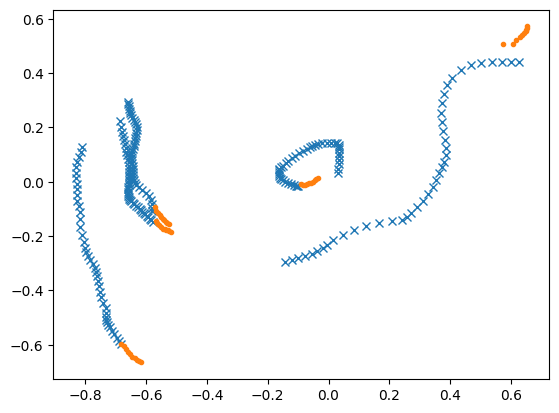

In [8]:
idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

fig, ax = plt.subplots()
_ = ax.plot(test_context.data[:, :, 0], test_context.data[:, :, 1], "x", color="C0")
_ = ax.plot(predicted_context[:, :, 0], predicted_context[:, :, 1], ".", color="C1")

Looks good. To visualize the tropical cyclone tracks and the predictions on the acutal map, we have to scale both back to the original coordinate system.

In [9]:
# #TODO The following generates TensorContextDatasets with smaller context length. This cannot be used as input to prediction for now.
# idx = np.random.randint(0, contexts["train"].shape[0])
# initial_context_arr = contexts['train'].data[:idx,:10]
# print(initial_context_arr.shape)
# print(type(initial_context_arr))
# initial_context = TensorContextDataset(initial_context_arr)
# print(initial_context.shape)
# print(type(initial_context))
# ts = predict_time_series(model, initial_context, n_steps=13)

Predictions are shown as dotted lines. Input test cyclone tracks are shown as solid lines.

In [10]:
idx = np.random.randint(0, contexts["test"].shape[0], 20)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

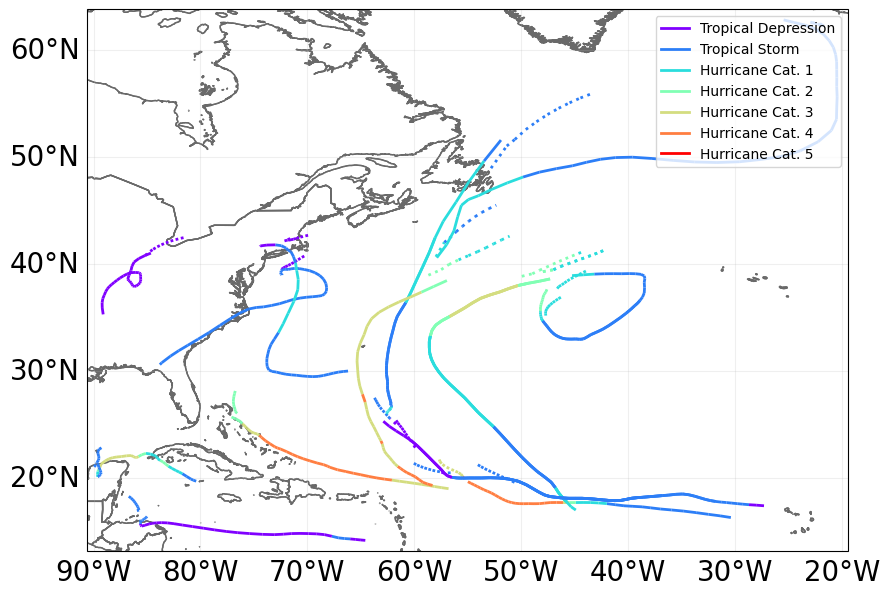

In [11]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context)
test_context_tc_tracs = TCTracks_from_TensorContextDataset(test_context_scaled, feature_list=feature_list)
predicted_context_tc_tracs = TCTracks_from_TensorContextDataset(predicted_context_scaled, feature_list=feature_list)

ax = predicted_context_tc_tracs.plot(linestyle="dotted")
_ = test_context_tc_tracs.plot(axis=ax, linestyle="solid")

Looks good, but arguably, the predictions of the model are not yet very good. This needs to be optimized!

## Import trained model

In [12]:
def load_model_results(flag_params: dict, path_training_results: str, train_stops):

    import_dir = os.path.join(
        path_training_results,
        "{}_yrange{}".format(
            flag_params["dataset"],
            "".join(map(str,flag_params["year_range"])),
        ),
        flag_params["model"],
    )

    model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}".format(
        flag_params["seed"],
        flag_params["koopman_kernel_length_scale"],
        flag_params["koopman_kernel_rank"],
        flag_params["koopman_kernel_reduced_rank"],
        flag_params["tikhonov_reg"],
        flag_params["koopman_kernel_num_centers"],
        flag_params["koopman_kernel_num_train_stops"],
        flag_params["context_length"],
    )

    results_file_name = os.path.join(import_dir, model_name)
    file_list = glob.glob(os.path.join(import_dir, "*train_steps*.pth"))
    results = {}
    for stop in train_stops:
    # for file_name in file_list:
        res= torch.load(
            # file_name,
            results_file_name + f"_train_steps{stop}.pth"
        )
        # results[res["train_stop"]] = res
        results[stop] = res
    # file_name_best = glob.glob(os.path.join(import_dir, "*best.pth"))[0]
    # results["best"] = torch.load(file_name_best)
    results["best"] = torch.load(results_file_name + f"_best.pth")

    return results

Set some specific parameters, such as the Koopman kernel model, and load default values for all other parameters.

In [13]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

train_stops = [316, 554, 973, 1707, 2995]
model_strings = ["Nystroem_RRR", "Randomized_RRR", "RRR"]

We first import results from the three different trained kernel models, and compare their fitting times and RMSE.

In [14]:
results = {}
for model_str in model_strings:
    flag_params = {
        "koopman_kernel_num_train_stops": 5,
        "year_range": [1990, 2000],
        "model": model_str,
    }
    flag_params = extend_by_default_flag_values(flag_params)

    results[model_str] = load_model_results(flag_params, path_training_results, train_stops)

C:\Users\Eric\AppData\Local\Temp\ipykernel_16548\3484018837.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res= torch.load(
C:\Users\Eric\AppData\Local\Temp\ipykernel_

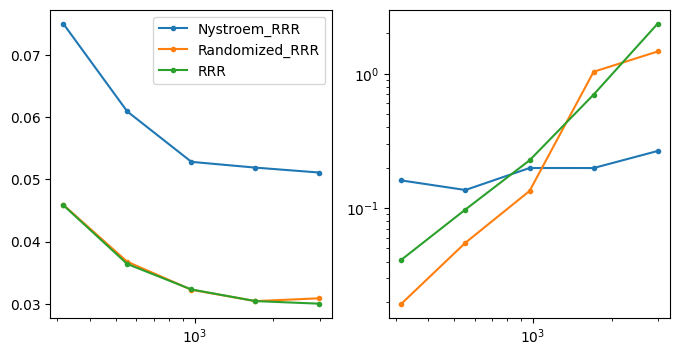

In [15]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)


for idx, model_str in enumerate(model_strings):

    train_stops = np.sort([x for x in results[model_str].keys() if isinstance(x, int)])
    rmse = [results[model_str][stop]["eval_rmse"] for stop in train_stops]
    fit_times = [results[model_str][stop]["fit_time"] for stop in train_stops]

    ax[0].plot(train_stops, rmse, color = f"C{idx}", label=model_str, marker=".")
    ax[1].plot(train_stops, fit_times, color = f"C{idx}", label=model_str, marker=".")

ax[0].set_xscale("log")
ax[0].legend()

ax[1].set_xscale("log")
ax[1].set_yscale("log")

### Plotting predictions

We use the best Nystroem_RRR model and forecast the cyclone tracks. We can use the CLIMADA plotting functions to generate nice plots of the predicted tracks.

Import training and test data, trained model and fitted scaler.

In [16]:
model_str = "Nystroem_RRR"
model = results[model_str]["best"]["model"]

scaler = results[model_str][train_stops[0]]["scaler"]

In [17]:
feature_list = ["lat", "lon", "max_sustained_wind"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

# scaler = LinearScaler()
eval_metric = RMSE_OneStep_TCTracks

# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="usa",
    year_range=flag_params["year_range"],
    basin="NA",
    correct_pres=False,
)

# TODO include random_state = seed in train_test_split
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1, random_state=flag_params["seed"])

Device cpu
2024-11-02 15:29:14,298 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-02 15:29:15,279 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 1990145N19276, 1990262N15315, 1991187N23264, 1991241N11329.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


We use the benchmark class to normalize the data and to bring the data in the correct shape.

In [18]:
benchmark = ModelBenchmark(
    feature_list,
    tc_tracks_train,
    tc_tracks_test,
    scaler=scaler,
    context_length=flag_params["context_length"],
)

benchmark._standardize_data()

contexts = {
    "train": benchmark.tensor_context_train,
    "test": benchmark.tensor_context_test,
}

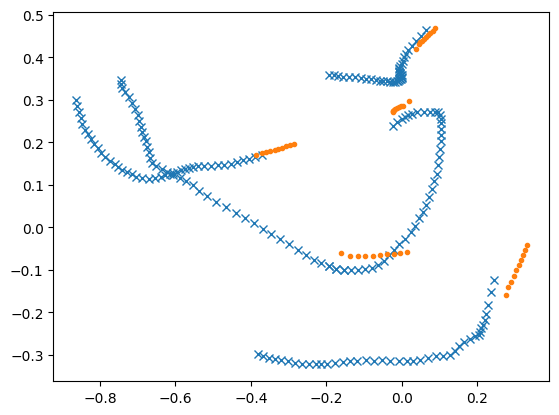

In [19]:
idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

fig, ax = plt.subplots()
_ = ax.plot(test_context.data[:, :, 0], test_context.data[:, :, 1], "x", color="C0")
_ = ax.plot(predicted_context[:, :, 0], predicted_context[:, :, 1], ".", color="C1")

Predictions are shown as dotted lines. Input test cyclone tracks are shown as solid lines.

In [20]:
idx = np.random.randint(0, contexts["test"].shape[0], 20)
test_context = contexts['test'][idx]
predicted_context = predict_time_series(model, test_context, n_steps=10)

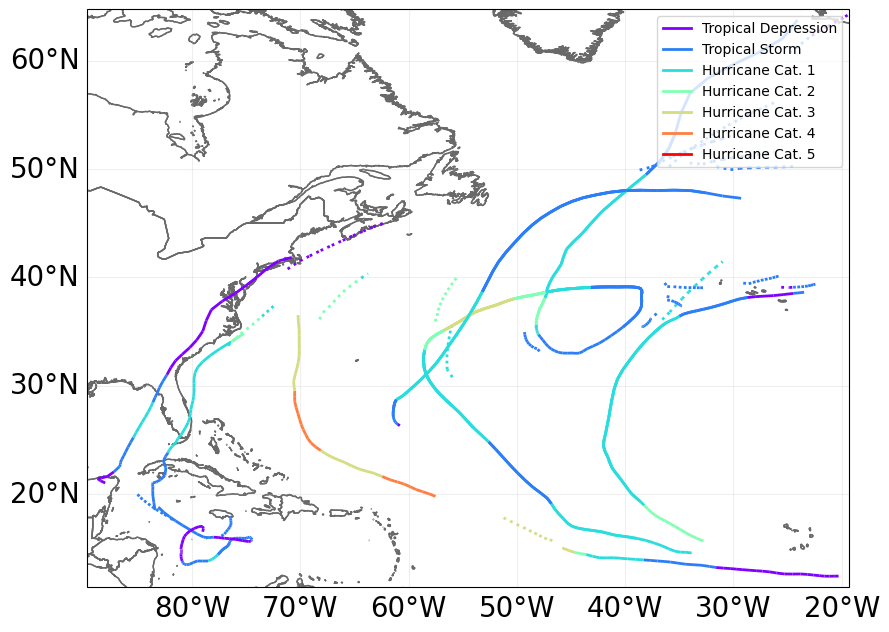

In [21]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context)
test_context_tc_tracs = TCTracks_from_TensorContextDataset(test_context_scaled, feature_list=feature_list)
predicted_context_tc_tracs = TCTracks_from_TensorContextDataset(predicted_context_scaled, feature_list=feature_list)

ax = predicted_context_tc_tracs.plot(linestyle="dotted")
_ = test_context_tc_tracs.plot(axis=ax, linestyle="solid")